# TWITTER  DATA COLLECTION & SENTIMENT ANALYSIS

Author : Ayesha Khatib

### Import packages

In [23]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from textblob import TextBlob 

import twitter_credentials
import numpy as np
import pandas as pd
import re 
import json
import datetime
import traceback
import sys 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import time
import seaborn as sns
from textblob import TextBlob as tb


### TWITTER CLIENT

In [24]:
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

### TWITTER AUTHENTICATER

In [25]:
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

### TWITTER STREAMER

In [26]:
class TwitterStreamer():
    
    #Class for streaming and processing live tweets.
    
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename):
 # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener,tweet_mode='extended')

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track = ['BTC','bitcoin'])

### TWEET COLLECTION

In [27]:
class Tweet:
    def __init__(self, text, sentiment_text, polarity, created_at):
        self.text = text
        self.sentiment_text = sentiment_text
        self.polarity = polarity
        self.created_at = created_at

    def __str__(self):
        return 'Sentiment: {} {} \nText: {}\nCreated_At: {}\n'.format(self.sentiment_text, self.polarity, self.text, self.created_at)


### TWITTER STREAM LISTENER

In [28]:

class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

### TWITTER ANALYZER -- TWEET CLEANING , SENTIMENT ANALYSIS & save to dataframe

In [29]:
class TweetAnalyzer():
    
    # Functionality for analyzing and categorizing content from tweets.
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        #sentiment= None
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
        

    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        #df['hashtags'] = np.array([tweet['entities']['hashtags'] for tweet in tweets])
        
        return df

### CALL ALL FUNCTIONS

                                              tweets                   id  \
0  “But What About the Warlords? “— Something Ama...  1065388098698297344   
1  RT @derekmagill: At what point is BTC no longe...  1065376329632239617   
2  RT @CryptoClubOCC: This dev onboarded 12 #BCH ...  1064586591455203328   
3  Announcing Neutrino Wallet for Bitcoin Cash: "...  1064576057884368896   
4  On November 15 2018, the Bitcoin Cash (BCH) ne...  1064573528077361152   
5  RT @cash_gateway: Hi, https://t.co/5wvvwBLIoD ...  1064567751199535104   
6  @manianban Bitcoin isn't a get rich quick sche...  1064375246201999360   
7  Introducing BadgerWallet: MetaMask for Bitcoin...  1064373524905656320   
8  @JynGyu Yes, hash rate decides. The ABC side h...  1063615110743244800   
9  @marvin_kassab @skylark_cash @rogerkver @Tweet...  1063614449976782849   

   len                date              source  likes  retweets sentiment  
0  128 2018-11-21 23:34:51  Twitter Web Client    156        77  positive  


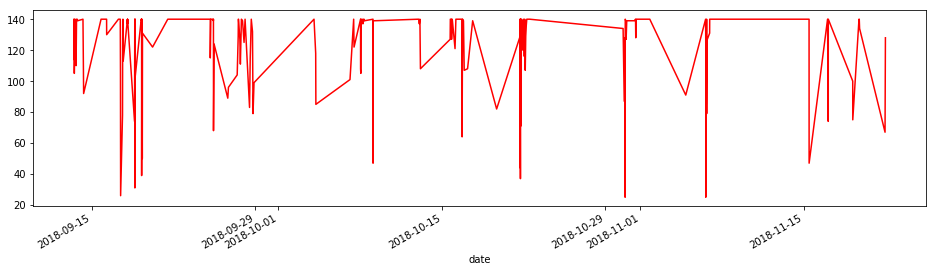

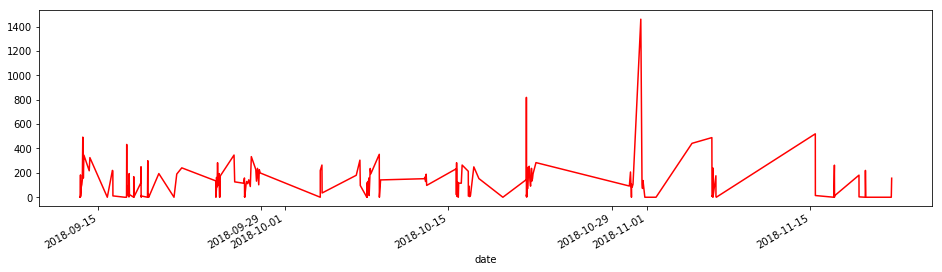

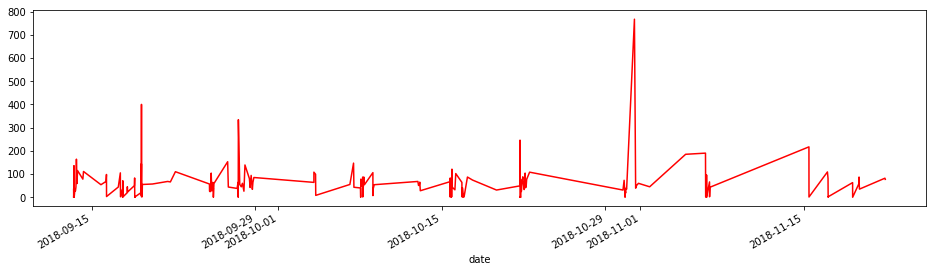

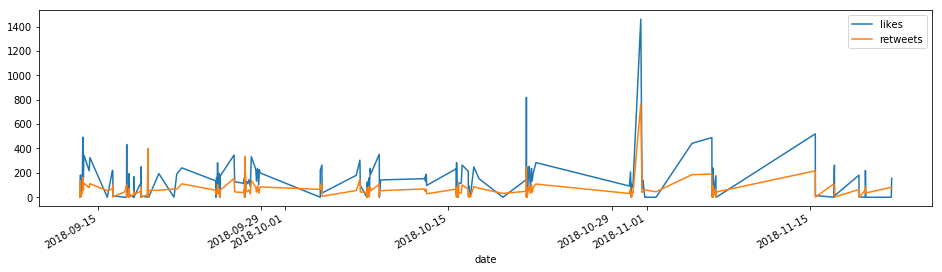

In [30]:
# Python interpreter reads a source file, it executes all of the code found in it.

if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()

    tweets = api.user_timeline(screen_name="Bitcoin",count=200)

    #print(dir(tweets[0]))
    #print(tweets[0].retweet_count)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    print(df.head(10))


    # Get average length over all tweets:
    print(np.mean(df['len']))

    # Get the number of likes for the most liked tweet:
    print(np.max(df['likes']))

    # Get the number of retweets for the most retweeted tweet:
    print(np.max(df['retweets']))
    
    #print(df.head(10))

    
    # Time Series
    time_likes = pd.Series(data=df['len'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), color='r')
    plt.show()
    
    time_favs = pd.Series(data=df['likes'].values, index=df['date'])
    time_favs.plot(figsize=(16, 4), color='r')
    plt.show()

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), color='r')
    plt.show()

    # Layered Time Series:
    time_likes = pd.Series(data=df['likes'].values, index=df['date'])
    time_likes.plot(figsize=(16, 4), label="likes", legend=True)

    time_retweets = pd.Series(data=df['retweets'].values, index=df['date'])
    time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)
    plt.show()

In [31]:
# Check the shape
df.shape

(200, 8)

In [32]:
# # Check the columns
df.columns

Index(['tweets', 'id', 'len', 'date', 'source', 'likes', 'retweets',
       'sentiment'],
      dtype='object')

In [33]:
# Save the file
df.to_csv('tweets_1stDec.csv', sep=',',encoding='utf-8' )

In [34]:
# Print the tweet
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


In [35]:
print(df["tweets"][0])

“But What About the Warlords? “— Something Amazing Just Happened on Bitcoin Cash. - by @bill_mcgonigle 

https://t.co/zlYBNPwKah


In [36]:
# Print the re-tweet count
print(tweets[0].retweet_count)

77


In [37]:
tweets;

In [38]:
# Print the unique outputs in the sentiment column.
df.sentiment.unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [39]:
# Print the sentiment column value count.
df.sentiment.value_counts()

neutral     99
positive    82
negative    19
Name: sentiment, dtype: int64

### Check for all stored data.

## Plotting Continuos Stream of data.

In [40]:
# Load the data in a variable.
pullData = pd.read_csv("tweets_1stDec.csv")
lines = pullData.sentiment
    
#print(lines)

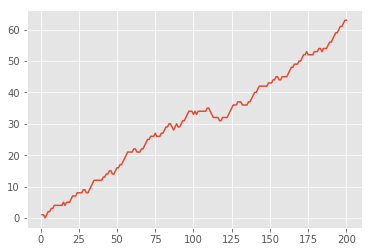

In [42]:
# Plot the twitter dtream of data.

style.use("ggplot")

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

# Function for live stream data and plotting animation.
def animate(i):
    pullData = pd.read_csv("tweets_1stDec.csv")
    lines = pullData.sentiment
    
    #print(lines)    
    
    xar = []
    yar = []

    x = 0
    y = 0

    for l in lines[-200:]:
        x += 1
        if "pos" in l:
            y += 1
        elif "neg" in l:
            y -= 1

        xar.append(x)
        yar.append(y)
        
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()

#### First dataframe didnot had sentiment column, I had not initially added 'sentiment' column.
#### Below steps are just for sentiment of the tweets.

### Combine all the Tweet data csv files

In [45]:
df1=pd.read_csv('./tweets_concat_result_19Nov.csv')

In [46]:
# Just verify if its read properly.
df1.shape

(913, 8)

In [47]:
# Check the head of the dataframe
df.head()

,tweets,id,len,date,source,likes,retweets,sentiment
0,“But What About the Warlords? “— Something Ama...,1065388098698297344,128,2018-11-21 23:34:51,Twitter Web Client,156,77,positive
1,RT @derekmagill: At what point is BTC no longe...,1065376329632239617,67,2018-11-21 22:48:05,Twitter Web Client,0,82,neutral
2,RT @CryptoClubOCC: This dev onboarded 12 #BCH ...,1064586591455203328,134,2018-11-19 18:29:57,Twitter Web Client,0,35,negative
3,"Announcing Neutrino Wallet for Bitcoin Cash: ""...",1064576057884368896,140,2018-11-19 17:48:05,Twitter Web Client,158,61,positive
4,"On November 15 2018, the Bitcoin Cash (BCH) ne...",1064573528077361152,140,2018-11-19 17:38:02,Twitter Web Client,220,87,positive


In [51]:
# Creating a small function to drop duplicates and remove the unwanted 'Unnamed : 0' column

def remove_duplicates(df_all):
    for df in df_all:
        #df.drop('Unnamed: 0',axis=1,inplace=True)
        df.drop_duplicates(inplace=True)

In [52]:
# Create a list consisting all the dataframes.
df_all=[df1,df]

In [53]:
# Call the above function with the list of all df's.
remove_duplicates(df_all)

In [54]:
# Combine all the dataframes using pd.concat method.

tweets_data=pd.concat(df_all,ignore_index=True)

In [55]:
# Check the shape of the resultant dataframe before checking further for duplicates.
tweets_data.shape

(1113, 8)

In [56]:
# Check for duplicates again after combining.
tweets_data.drop_duplicates(inplace=True)

In [57]:
# Check the dimension after the duplicates.
tweets_data.shape

(1113, 8)

In [58]:
# Check the contents of the dataframe
tweets_data.head()

,tweets,id,len,date,source,likes,retweets,sentiment
0,Bitcoin Cash Continues to Skyrocket 15% to $53...,1.059190e+18,91,4/11/2018 21:10,Twitter Web Client,396,157,positive
1,RT @CoinSpice: Leaders in the #BCH space @ryan...,1.058070e+18,140,1/11/2018 19:14,Twitter Web Client,0,42,neutral
2,RT @HelloVoltaire: You can now use @handcashap...,1.057730e+18,140,31/10/2018 20:12,Twitter Web Client,0,49,neutral
3,"""The behemoth cryptocurrency exchange Coinbase...",1.057670e+18,140,31/10/2018 16:25,TweetDeck,117,44,positive
4,Pandacash is a “one-click” Bitcoin Cash blockc...,1.057650e+18,140,31/10/2018 15:24,TweetDeck,58,36,positive


In [59]:
# Just verifying if the sentiment column has any entries null.
tweets_data.sentiment.isnull().sum()

0

In [60]:
# Save the file.
tweets_data.to_csv('./tweets_concat_result_1stDec.csv',index=False, encoding='utf-8')

In [61]:
# Read the csv file.
df= pd.read_csv('./tweets_concat_result_1stDec.csv')

In [64]:
# Print the head.
df.tail()

,tweets,id,len,date,source,likes,retweets,sentiment
1108,RT @money_button: We launched.\r\n\r\nhttps://...,1.040207e+18,140,2018-09-13 11:53:38,Twitter Web Client,0,136,positive
1109,@jdsmithies @memobch @YoursOrg @money_button @...,1.040202e+18,140,2018-09-13 11:33:08,Twitter Web Client,2,0,neutral
1110,RT @btccom_official: We are happy to announce ...,1.040198e+18,140,2018-09-13 11:18:32,Twitter Web Client,0,37,positive
1111,@DeviousPL @memobch @YoursOrg @money_button @M...,1.040197e+18,114,2018-09-13 11:15:49,Twitter Web Client,3,0,positive
1112,@jdsmithies @memobch @YoursOrg @money_button @...,1.040197e+18,139,2018-09-13 11:15:22,Twitter Web Client,1,0,neutral


In [65]:
df.date.min()

'1/11/2018 19:14'

### Subjectivity score :
A score of subjectivity assigned to each tweet is based on whether it is representing a subjective meaning or an objective meaning; the range of subjectivity score is also from 0 to 1 where a value near to 0 represents objective and near to 1 subjective.

In [66]:
# Getting the subjectivity and polarity score for the sentiments of the tweets.

tweet = df['tweets']
# Initialize the polarity and subjectivity lists.
pol = []
sub = []

# from textblob import TextBlob as tb
# tb is the TextBlob package.

for j in tweet:
    tx = tb(j)
    pol.append(tx.sentiment.polarity)
    sub.append(tx.sentiment.subjectivity)

In [68]:
# Create dataframes with polarity and subjectivity columns.

df_tweet = pd.DataFrame({"polarity":pol,"subjectivity":sub})
df['polarity']= df_tweet ['polarity']
df['subjectivity']= df_tweet ['subjectivity']

df_tweet.head()

,polarity,subjectivity
0,0.000000,0.000000
1,-0.155556,0.288889
2,0.000000,0.000000
3,0.250000,0.300000
4,0.500000,0.500000


In [69]:
df.head()
#df.shape

,tweets,id,len,date,source,likes,retweets,sentiment,polarity,subjectivity
0,Bitcoin Cash Continues to Skyrocket 15% to $53...,1.059190e+18,91,4/11/2018 21:10,Twitter Web Client,396,157,positive,0.000000,0.000000
1,RT @CoinSpice: Leaders in the #BCH space @ryan...,1.058070e+18,140,1/11/2018 19:14,Twitter Web Client,0,42,neutral,-0.155556,0.288889
2,RT @HelloVoltaire: You can now use @handcashap...,1.057730e+18,140,31/10/2018 20:12,Twitter Web Client,0,49,neutral,0.000000,0.000000
3,"""The behemoth cryptocurrency exchange Coinbase...",1.057670e+18,140,31/10/2018 16:25,TweetDeck,117,44,positive,0.250000,0.300000
4,Pandacash is a “one-click” Bitcoin Cash blockc...,1.057650e+18,140,31/10/2018 15:24,TweetDeck,58,36,positive,0.500000,0.500000


In [70]:
# Create three different data frames for the three polarities.

#negative = pd.DataFrame()
#positive= pd.DataFrame()
#neutral = pd.DataFrame()

df['neg_score'] = df['polarity']<= -0.5
df['pos_score']  = df['polarity']>=  0.5
df['neu_score']  = (df['polarity'] > -0.5) & (df['polarity'] < 0.5)

In [71]:
df.head()

,tweets,id,len,date,source,likes,retweets,sentiment,polarity,subjectivity,neg_score,pos_score,neu_score
0,Bitcoin Cash Continues to Skyrocket 15% to $53...,1.059190e+18,91,4/11/2018 21:10,Twitter Web Client,396,157,positive,0.000000,0.000000,False,False,True
1,RT @CoinSpice: Leaders in the #BCH space @ryan...,1.058070e+18,140,1/11/2018 19:14,Twitter Web Client,0,42,neutral,-0.155556,0.288889,False,False,True
2,RT @HelloVoltaire: You can now use @handcashap...,1.057730e+18,140,31/10/2018 20:12,Twitter Web Client,0,49,neutral,0.000000,0.000000,False,False,True
3,"""The behemoth cryptocurrency exchange Coinbase...",1.057670e+18,140,31/10/2018 16:25,TweetDeck,117,44,positive,0.250000,0.300000,False,False,True
4,Pandacash is a “one-click” Bitcoin Cash blockc...,1.057650e+18,140,31/10/2018 15:24,TweetDeck,58,36,positive,0.500000,0.500000,False,True,False


In [ ]:
# Some data manipulation for renaming the column names.
#negative['neg_pol'] = negative['polarity']
#negative['neg_subjectivity'] = negative['subjectivity']

# Dropping the duplicate columns.
#negative.drop(['subjectivity'],axis=1,inplace=True)
#negative.drop(['polarity'],axis=1,inplace=True)

# Print the head for negative scores.
negative.head()

In [ ]:
# Some data manipulation for renaming the column names.
#positive['pos_pol'] = positive['polarity']
#positive['pos_subjectivity'] = positive['subjectivity']

# Dropping the duplicate columns.
#positive.drop(['subjectivity'],axis=1,inplace=True)
#positive.drop(['polarity'],axis=1,inplace=True)

# Print the head for positive scores.
positive.head()

In [ ]:
# Some data manipulation for renaming the column names.
#neutral['neu_pol'] = neutral['polarity']
#neutral['neu_subjectivity'] = neutral['subjectivity']

# Dropping the duplicate columns.
#neutral.drop(['subjectivity'],axis=1,inplace=True)
#neutral.drop(['polarity'],axis=1,inplace=True)

# Print the head for neutral scores.
neutral.head()

objectivity = 1. - (pos_score + neg_score)
pos_vs_neg = pos_score - neg_score

In [ ]:

df_new=pd.DataFrame()
df_new['neg_score'] = negative['neg_pol']
df_new['pos_score'] = positive['pos_pol']


In [ ]:
df_new.pos_score.notnull()